In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from keras.layers import Dropout
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
df=pd.read_csv("monthlyMConsumption.csv")
df.head(5)

,DEVICE_CONSUMPTION_DATETIME,CONSUMPTION_VALUE
0,2018-11,846.3190
1,2018-12,1269.0435
2,2019-01,67022.9660
3,2019-02,89886.4540
4,2019-03,118191.7470


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
DEVICE_CONSUMPTION_DATETIME    39 non-null object
CONSUMPTION_VALUE              39 non-null float64
dtypes: float64(1), object(1)
memory usage: 752.0+ bytes


In [4]:
df_supervised = df.copy()
#adding lags
for inc in range(1,15):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['CONSUMPTION_VALUE'].shift(inc)


In [19]:
df_supervised.shape

(25, 16)

In [6]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from keras import callbacks
from keras.layers import Dropout

kfold=KFold(10,True,7)
cvscoresmae = []
cvscoresmse = []
TargetVariable=df_supervised[['CONSUMPTION_VALUE']]
Predictors=df_supervised[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','lag_6','lag_7','lag_8','lag_9','lag_10', 
                          'lag_11', 'lag_12', 'lag_13', 'lag_14']]
#                           , 
#             'lag_13', 'lag_14','lag_15','lag_16']]
# Predictors=df_supervised[['lag_1', 'lag_2', 'lag_3', 'lag_4','lag_5','lag_6','lag_7','lag_8','lag_9','lag_10']]
# from sklearn.model_selection import train_test_split
x=Predictors.values
y=TargetVariable.values
scaler = MinMaxScaler()
x_sc=scaler.fit_transform(x)
y_sc=scaler.fit_transform(y)
# df_supervised=pd.DataFrame(df_sc)

for train, test in kfold.split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(x_sc, y_sc, test_size = 0.2, random_state = 0)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(80, batch_input_shape=(1, 1,14),activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mse', optimizer='adam',metrics=['mean_absolute_error','mse'])
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
    history=model.fit(X_train, y_train,validation_split=0.33, epochs=50, batch_size=1, verbose=1,callbacks =[earlystopping], shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=0)
   
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    cvscoresmse.append(scores[0] * 100)
    cvscoresmae.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscoresmae), np.std(cvscoresmae)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscoresmse), np.std(cvscoresmse)))
    

Epoch 1/50
13/13 [==============================] - 4s 90ms/step - loss: 0.3362 - mean_absolute_error: 0.5369 - mse: 0.3362 - val_loss: 0.1965 - val_mean_absolute_error: 0.4043 - val_mse: 0.1965
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 0.1899 - mean_absolute_error: 0.4003 - mse: 0.1899 - val_loss: 0.0942 - val_mean_absolute_error: 0.2904 - val_mse: 0.0942
Epoch 3/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0820 - mean_absolute_error: 0.2605 - mse: 0.0820 - val_loss: 0.0338 - val_mean_absolute_error: 0.1695 - val_mse: 0.0338
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0311 - mean_absolute_error: 0.1389 - mse: 0.0311 - val_loss: 0.0215 - val_mean_absolute_error: 0.0987 - val_mse: 0.0215
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0129 - mean_absolute_error: 0.1032 - mse: 0.0129 - val_loss: 0.0239 - val_mean_absolute_error: 0.1164 - val_mse: 0.0239
Epoch 6/50
13/13 [=======

In [17]:
df.info()
# history.history

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
DEVICE_CONSUMPTION_DATETIME    39 non-null object
CONSUMPTION_VALUE              39 non-null float64
dtypes: float64(1), object(1)
memory usage: 752.0+ bytes


dict_keys(['loss', 'mean_absolute_error', 'mse', 'val_loss', 'val_mean_absolute_error', 'val_mse'])


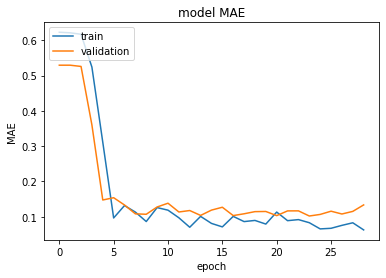

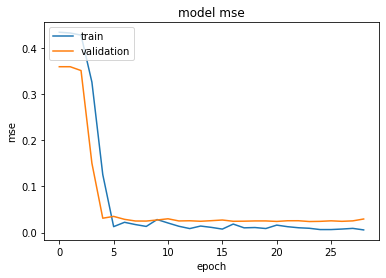

In [9]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
dd=np.array([[[479721.933,810968.646,967605.001,924280.386,863794.712,695276.854,556731.260,352800.174,463312.506,465016.772,290483.798,429849.187,337839.562,340927.967]]])
zz=model.predict(dd)
zz


#94957.945----->1707564.2   4months
#94957.945----->1412605.5   6months
#94957.945----->1238528.5   8month
#94957.945----->1645342.2   10months
#94957.945----->597904.1    12months
#94957.945----->1088414.6  14months




# model.predict([])

array([[745931.2]], dtype=float32)

In [11]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#       f.write(tflite_model)

In [12]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [13]:
from keras.utils.vis_utils import plot_model

In [14]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.metrics_names

['loss', 'mean_absolute_error', 'mse']